## Value-at-Risk: Forecast Evaluation

**Functions**

`sm.OLS`, `stats.bernoulli`

### Exercise 60\n
    
Compare this VaR to the HS VaR in the previous example.

import pandas as pd

In [20]:
import pandas as pd
# Load Data
sp500 = pd.read_hdf("./data/arch-data.h5", "sp500")        
eurusd = pd.read_hdf("./data/arch-data.h5", "eurusd")

sp500_returns = 100 * sp500.SP500.pct_change().dropna()
eurusd_returns = 100 * eurusd.DEXUSEU.pct_change().dropna()

with pd.HDFStore("./data/hs-var.h5", mode="r") as hdf:
    sp500_hs = hdf.get("sp500_var")
    eurusd_hs = hdf.get("eurusd_var")
with pd.HDFStore("./data/fhs-var.h5", mode="r") as hdf:
    sp500_fhs = hdf.get("sp500_var")
    eurusd_fhs = hdf.get("eurusd_var")

# Rename columns to distinguish
sp500_hs.columns = [c.replace("VaR","HS VaR") for c in sp500_hs.columns]
eurusd_hs.columns = [c.replace("VaR","HS VaR") for c in eurusd_hs.columns]

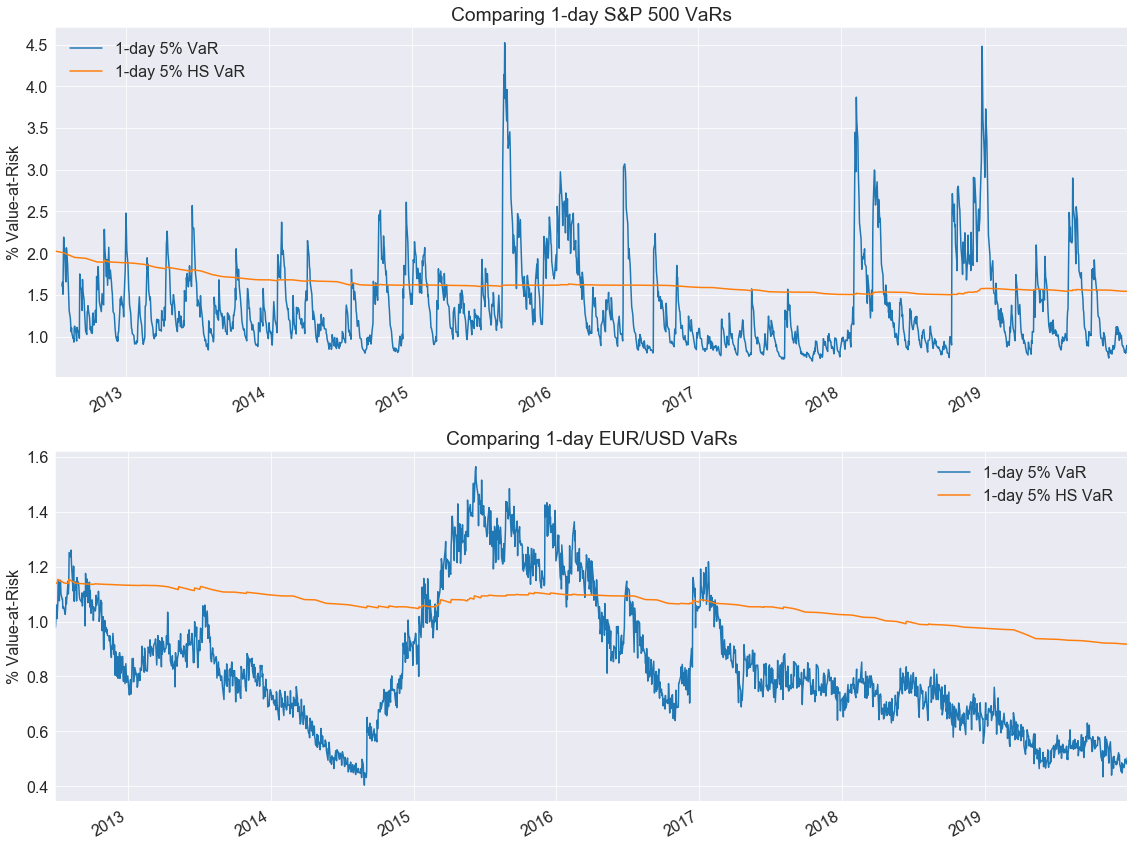

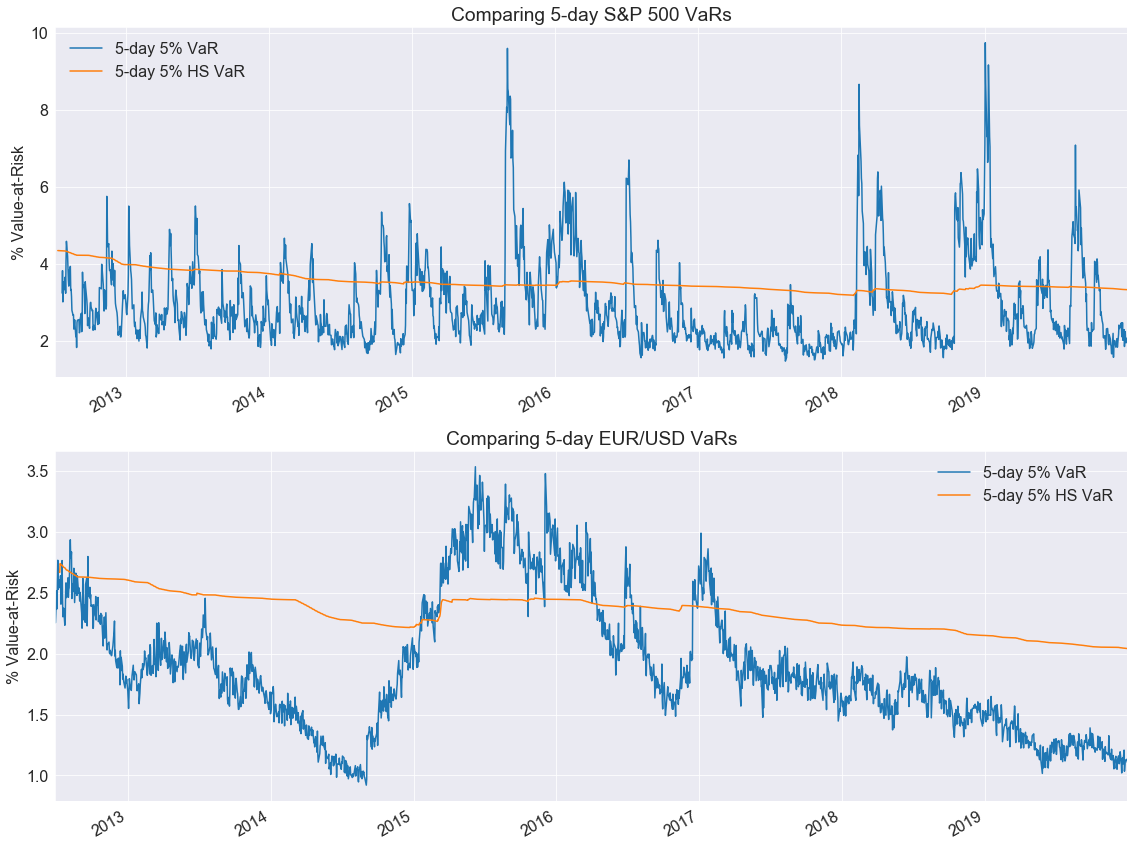

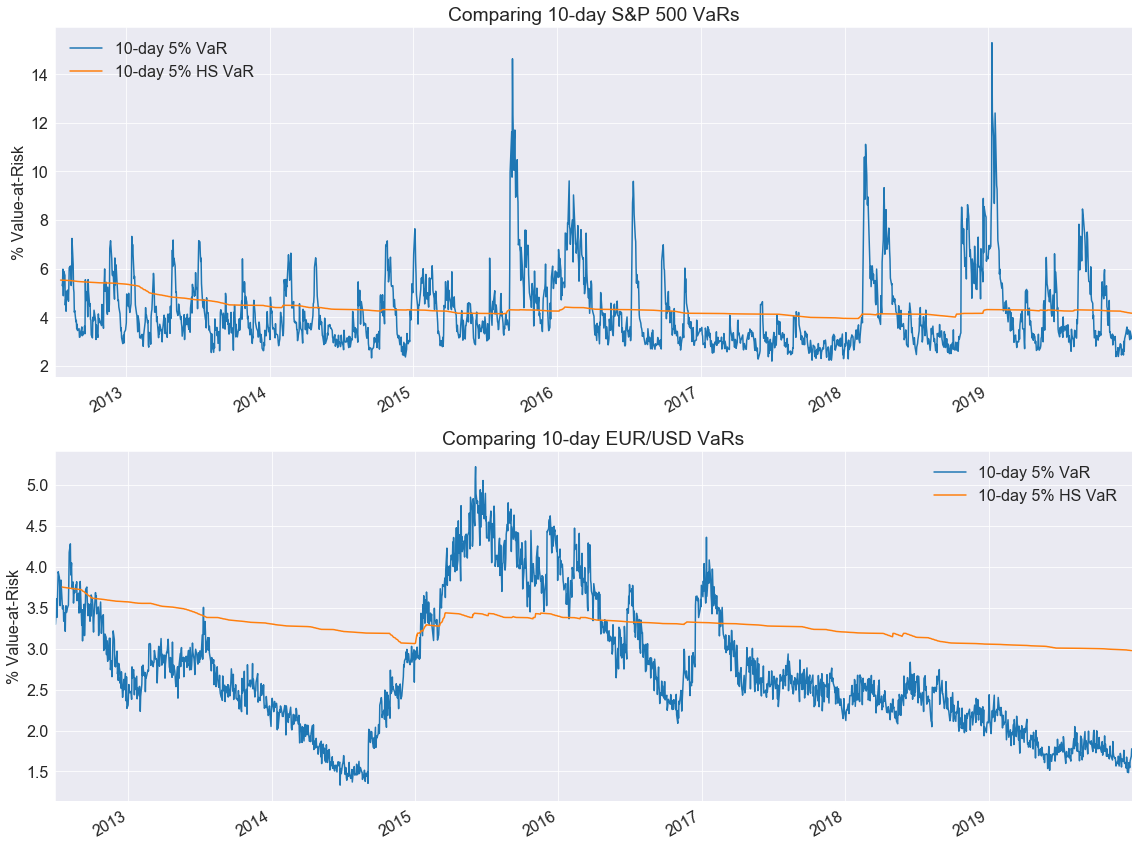

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
plt.rc("figure", figsize=(16,12))
plt.rc("font", size=16)

sp500_var = pd.concat([sp500_hs, sp500_fhs],axis=1)
eurusd_var = pd.concat([eurusd_hs, eurusd_fhs], axis=1)

for h in (1,5,10):
    fig, axes = plt.subplots(2,1)
    cols =[f"{h}-day 5% VaR", f"{h}-day 5% HS VaR"]
    ax = sp500_var[cols].plot(ax=axes[0],legend=False)
    ax.set_title(f"Comparing {h}-day S&P 500 VaRs")
    ax.set_xlabel(None)
    ax.set_ylabel("% Value-at-Risk")
    ax.legend(frameon=False)
    #plt.legend(frameon=False)
    
    ax = eurusd_var[cols].plot(ax=axes[1], legend=False)
    ax.set_title(f"Comparing {h}-day EUR/USD VaRs")
    ax.set_xlabel(None)
    ax.set_ylabel("% Value-at-Risk")
    plt.legend(frameon=False)
    fig.tight_layout(pad=1.0)

### Exercise 61
Evaluate the FHS and HS VaR forecasts constructed in the previous exercises using:

* HIT tests
* The Bernoulli test for unconditionally correct VaR
* Christoffersen’s test for conditionally correct VaR


hit_fhs    0.013881
hit_hs     0.033636
dtype: float64
          hit_fhs    hit_hs
hit_fhs  1.000000  0.585327
hit_hs   0.585327  1.000000


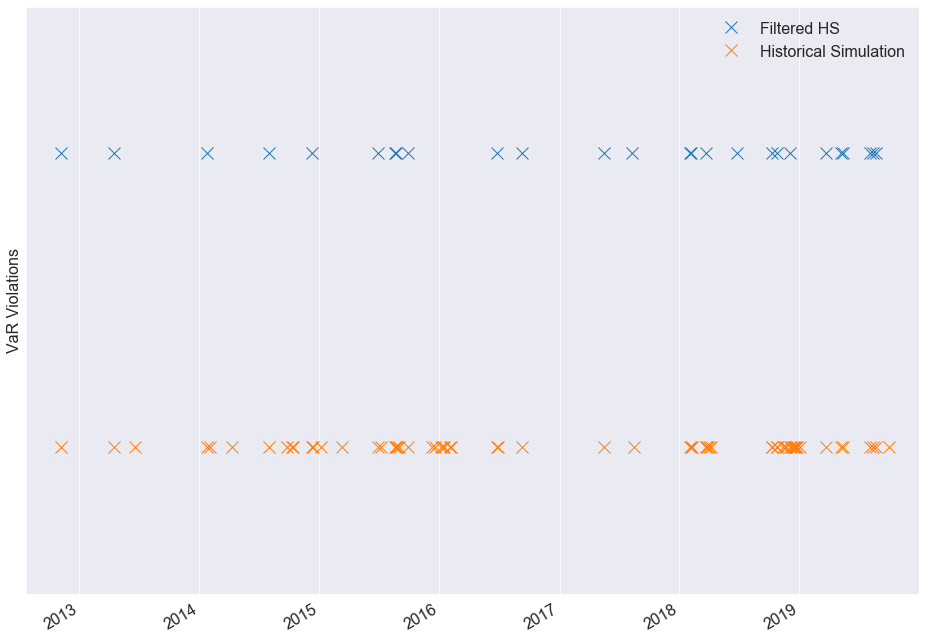

In [47]:
# Construct HITS
cols =["1-day 5% VaR", f"1-day 5% HS VaR"]
combined = pd.concat([sp500_returns, sp500_var[cols]], axis=1).dropna()
combined.columns = ["ret","fhs","hs"]
hit_fhs = combined.ret < -combined.fhs
hit_hs = combined.ret < -combined.hs
hits = pd.DataFrame({"hit_fhs":hit_fhs,"hit_hs":hit_hs}).astype("float")
print(hits.mean())
print(hits.corr())
import numpy as np
temp = hits.replace(0.0,np.nan)
temp.iloc[:,0] += 0.05
temp.iloc[:,1] -= 0.05
temp.columns = ["Filtered HS", "Historical Simulation"]
ax = temp.plot(marker="x",linestyle="none",legend=False, markersize=12)
ax.set_ylim(0.9,1.10)
ax.set_yticks([])
ax.set_ylabel("VaR Violations")
ax.set_xlabel(None)
ax.legend(frameon=False)

In [48]:
from scipy import stats
phat = hits.mean(0)
for col in hits:
    hit = hits[col]
    phat = hit.mean()
    llf = stats.bernoulli(phat).logpmf(hit).sum()
    llf0 = stats.bernoulli(0.05).logpmf(hit).sum()
    lr = 2 * (llf - llf0)
    pval = 1 - stats.chi2(1).cdf(lr)
    print(f"Method: {col} LR: {lr} P-value: {pval}")


Method: hit_fhs LR: 71.2036991699731 P-value: 0.0
Method: hit_hs LR: 11.874810141248076 P-value: 0.0005689826984602853


In [64]:
import statsmodels.api as sm

for col in hits:
    hit = hits[col] - 0.05
    lags = [hit.shift(i+1) for i in range(5)]
    lags = pd.concat(lags,axis=1)
    var_col = "fhs" if "fhs" in col else "hs"
    var = combined[var_col]
    data = pd.concat([hit, var, lags], axis=1).dropna()
    y = data.iloc[:,0]
    x = sm.add_constant(data.iloc[:,1:])
    x.columns = ["const","var"] + [f"hit_L_{i}" for i in range(1,6)]
    res = sm.OLS(y, x).fit()
    r = np.eye(7)
    joint = res.wald_test(r)
    stat = np.squeeze(joint.statistic)
    print("*"*80)
    print(col)
    print(res.summary())
    print(f"Stat: {stat}, P-value: {joint.pvalue}")
    print("*"*80)
    
    

********************************************************************************
hit_fhs
                            OLS Regression Results                            
Dep. Variable:                hit_fhs   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     14.32
Date:                Wed, 26 Feb 2020   Prob (F-statistic):           5.18e-16
Time:                        11:16:36   Log-Likelihood:                 1397.1
No. Observations:                1868   AIC:                            -2780.
Df Residuals:                    1861   BIC:                            -2741.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------

hit_fhs    0.040043
hit_hs     0.035238
dtype: float64
          hit_fhs    hit_hs
hit_fhs  1.000000  0.743743
hit_hs   0.743743  1.000000


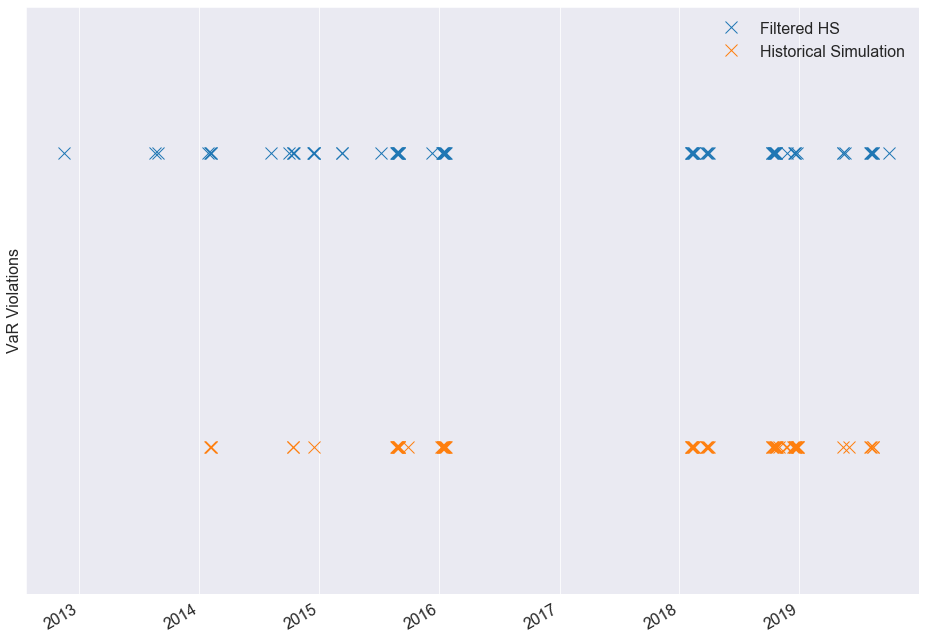

In [70]:
# Construct HITS
cols =["10-day 5% VaR", f"10-day 5% HS VaR"]
rets_10 = 100 * sp500.SP500.pct_change(10)
combined = pd.concat([rets_10, sp500_var[cols]], axis=1).dropna()
combined.columns = ["ret","fhs","hs"]
hit_fhs = combined.ret < -combined.fhs
hit_hs = combined.ret < -combined.hs
hits = pd.DataFrame({"hit_fhs":hit_fhs,"hit_hs":hit_hs}).astype("float")
print(hits.mean())
print(hits.corr())
import numpy as np
temp = hits.replace(0.0,np.nan)
temp.iloc[:,0] += 0.05
temp.iloc[:,1] -= 0.05
temp.columns = ["Filtered HS", "Historical Simulation"]
ax = temp.plot(marker="x",linestyle="none",legend=False, markersize=12)
ax.set_ylim(0.9,1.10)
ax.set_yticks([])
ax.set_ylabel("VaR Violations")
ax.set_xlabel(None)
ax.legend(frameon=False)

In [81]:
horizon=10
for col in hits:
    hit = hits[col] - 0.05
    lags = [hit.shift(i+horizon) for i in range(5)]
    lags = pd.concat(lags,axis=1)
    var_col = "fhs" if "fhs" in col else "hs"
    var = combined[var_col]
    data = pd.concat([hit, var, lags], axis=1).dropna()
    y = data.iloc[:,0]
    x = sm.add_constant(data.iloc[:,1:])
    x.columns = ["const","var"] + [f"hit_L_{horizon+i}" for i in range(1,6)]
    bw = int(1.2 * y.shape[0] ** (2/5))
    res = sm.OLS(y, x).fit(cov_type="HAC", cov_kwds={"maxlags": bw})
    r = np.eye(7)
    joint = res.wald_test(r)
    stat = np.squeeze(joint.statistic)

    joint_ex = res.wald_test(r[1:,:])
    stat_ex = np.squeeze(joint_ex.statistic)

    print("*"*80)
    print(col)
    print(res.summary())
    print(f"Stat: {stat}, P-value: {joint.pvalue}")
    print(f"Stat ex. constant: {stat_ex}, P-value ex. constant: {joint_ex.pvalue}")
    print("*"*80)


********************************************************************************
hit_fhs
                            OLS Regression Results                            
Dep. Variable:                hit_fhs   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.963
Date:                Wed, 26 Feb 2020   Prob (F-statistic):            0.00699
Time:                        11:29:41   Log-Likelihood:                 387.82
No. Observations:                1859   AIC:                            -761.6
Df Residuals:                    1852   BIC:                            -722.9
Df Model:                           6                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------